In [3]:
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import yfinance as yf
import requests
from  calculate_selic import calculate_average_selic_annual
from asset_download import stocks_dataframe

from pypfopt import EfficientFrontier, EfficientSemivariance
from pypfopt.cla import CLA
from pypfopt import expected_returns
from pypfopt import risk_models

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy import stats
import plotly.express as px
import pickle

In [ ]:
start = dt.date(2015,1,1)
end = dt.date.today()
#end = 10
type(end) == dt.date

In [4]:
stocks_cod = ['ABEV3','PETR3' ,'MGLU3','ITUB3','ALPA3', 'VIVT3', 'WEGE3', 'VALE3', 'BBAS3']
stocks_cod = [stock +'.SA' for stock in stocks_cod]
stocks_cod

['ABEV3.SA',
 'PETR3.SA',
 'MGLU3.SA',
 'ITUB3.SA',
 'ALPA3.SA',
 'VIVT3.SA',
 'WEGE3.SA',
 'VALE3.SA',
 'BBAS3.SA']

In [ ]:
 def stocks_dataframe(start, end = 0, *stocks_id:list):   
    
    if end == 0:
        end = dt.date.today()
        
    
    # convert string date in datetime
    start = dt.datetime.strptime(start, '%d/%m/%Y')
    
    if type(end) != dt.date:
        end  = dt.datetime.strptime(end, '%d/%m/%Y')
    
    stock_data = pd.DataFrame()
    
   
        
        # iterate stocks args  
    for i in stocks_id:


        for asset in i:

            try:
                # get close data stocks in yahoo finance API
                close = yf.download(asset, start=start, end=end)['Adj Close']

                # add adj close value
                stock_data[asset] = close
            except Exception as e:
                print(f"Error downloading data for {asset}: {str(e)}")


    stock_data.fillna(0, inplace = True)
    return stock_data

In [6]:
day = 365 * 3
date___= dt.datetime.strftime(dt.date.today() - dt.timedelta(days = day),"%d/%m/%Y")
data = stocks_dataframe(date___,0,stocks_cod)
columns = data.columns
index = data.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
data.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-12,12.029677,9.475524,15.866846,21.867254,22.633282,40.505302,21.260088,38.901443,26.976826
2020-06-15,11.905570,9.511213,16.338261,21.268509,22.613516,39.248383,21.269699,39.251125,26.750322
2020-06-16,11.754867,9.903796,16.375477,21.715324,22.633282,39.945766,21.505117,40.351147,27.098158
2020-06-17,12.206976,9.926103,16.670731,21.911936,24.036743,40.164719,22.177750,40.941223,27.907057
2020-06-18,12.127192,10.082243,17.293497,22.474922,24.066395,40.943192,22.163342,40.919369,27.826164


In [8]:
def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

data = pd.DataFrame(columns = columns, data = replaceZeroes(data.values), index = index)
returns = data.pct_change().iloc[1:].apply(lambda x: np.log1p(x)).dropna()

# annual returns
mean = returns.mean() *252

# deviation
sigma =  returns.std(axis = 0) * np.sqrt(252)

cov_matrix = returns.cov() * 252
cov_matrix

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
ABEV3.SA,0.081155,0.036921,0.039122,0.036843,0.023409,0.021297,0.030315,0.009375,0.038423
PETR3.SA,0.036921,0.170120,0.039558,0.053112,0.018707,0.014127,0.024413,0.046560,0.078227
MGLU3.SA,0.039122,0.039558,0.458559,0.042356,0.098425,0.027025,0.070775,0.019307,0.052488
ITUB3.SA,0.036843,0.053112,0.042356,0.086244,0.024156,0.020057,0.027321,0.022853,0.059503
ALPA3.SA,0.023409,0.018707,0.098425,0.024156,0.205550,0.016384,0.038619,0.005785,0.023554
VIVT3.SA,0.021297,0.014127,0.027025,0.020057,0.016384,0.051011,0.017685,0.001716,0.022624
WEGE3.SA,0.030315,0.024413,0.070775,0.027321,0.038619,0.017685,0.124079,0.019784,0.026091
VALE3.SA,0.009375,0.046560,0.019307,0.022853,0.005785,0.001716,0.019784,0.121326,0.023208
BBAS3.SA,0.038423,0.078227,0.052488,0.059503,0.023554,0.022624,0.026091,0.023208,0.102623


In [9]:
returns.head()

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA
Date,,,,,,,,,
2020-06-15,-0.010370,0.003759,0.029278,-0.027763,-0.000874,-0.031523,0.000452,0.008949,-0.008432
2020-06-16,-0.012739,0.040447,0.002275,0.020791,0.000874,0.017612,0.011007,0.027640,0.012919
2020-06-17,0.037740,0.002250,0.017870,0.009013,0.060162,0.005466,0.030799,0.014518,0.029414
2020-06-18,-0.006557,0.015608,0.036676,0.025369,0.001233,0.019197,-0.000650,-0.000534,-0.002903
2020-06-19,0.011628,-0.014260,0.024098,0.048127,0.018312,0.009070,0.001732,-0.017964,-0.013462


In [42]:
def return_portfolio(w, ret):
    # return capm
    return  (w* ret).sum()

    #return  expected_returns.capm_return(data)

def cov_portfolio(w, cov_matrix):
    # risk calculation    
    return np.sqrt(np.dot(w.T, (np.dot(cov_matrix, w))))
    #return risk_models.CovarianceShrinkage(data).ledoit_wolf()


In [ ]:
"""
def calculate_average_selic_annual(year1, year2 = 0):
    
    import datetime as dt
    import pandas as pd
    
    if year2 == 0:
        year2 = dt.date.today().year
        
    if year1 > year2:
        
        raise ValueError("Primeiro ano deve ser menor que o segundo ano.")
        
    # api extract selic
    serie = 432
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{serie}/dados?formato=json'
    data = pd.read_json(url)
    
    # convert to datetime
    data['data'] = pd.to_datetime(data['data'], dayfirst = True)
    
    # year column, grouping by year and aggregate average
    data['ano'] = data['data'].dt.year
    selic_annual = data.groupby('ano')['valor'].mean()
    
    # average selic rate of the years
    rate_w_risk = selic_annual[(selic_annual.index > year1) & (selic_annual.index < year2)].mean()
    
    return round(rate_w_risk/100,4)

In [43]:
tax_w_risk = calculate_average_selic_annual(2020)
tax_w_risk

0.0854

In [45]:
columns = [x for x in data.columns]
lista = ['Retorno P %', 'Risco %', 'Indice Sharpe']
columns.extend(lista)

simulacao = pd.DataFrame(columns=[columns])
simulacao

,ABEV3.SA,PETR3.SA,MGLU3.SA,ITUB3.SA,ALPA3.SA,VIVT3.SA,WEGE3.SA,VALE3.SA,BBAS3.SA,Retorno P %,Risco %,Indice Sharpe


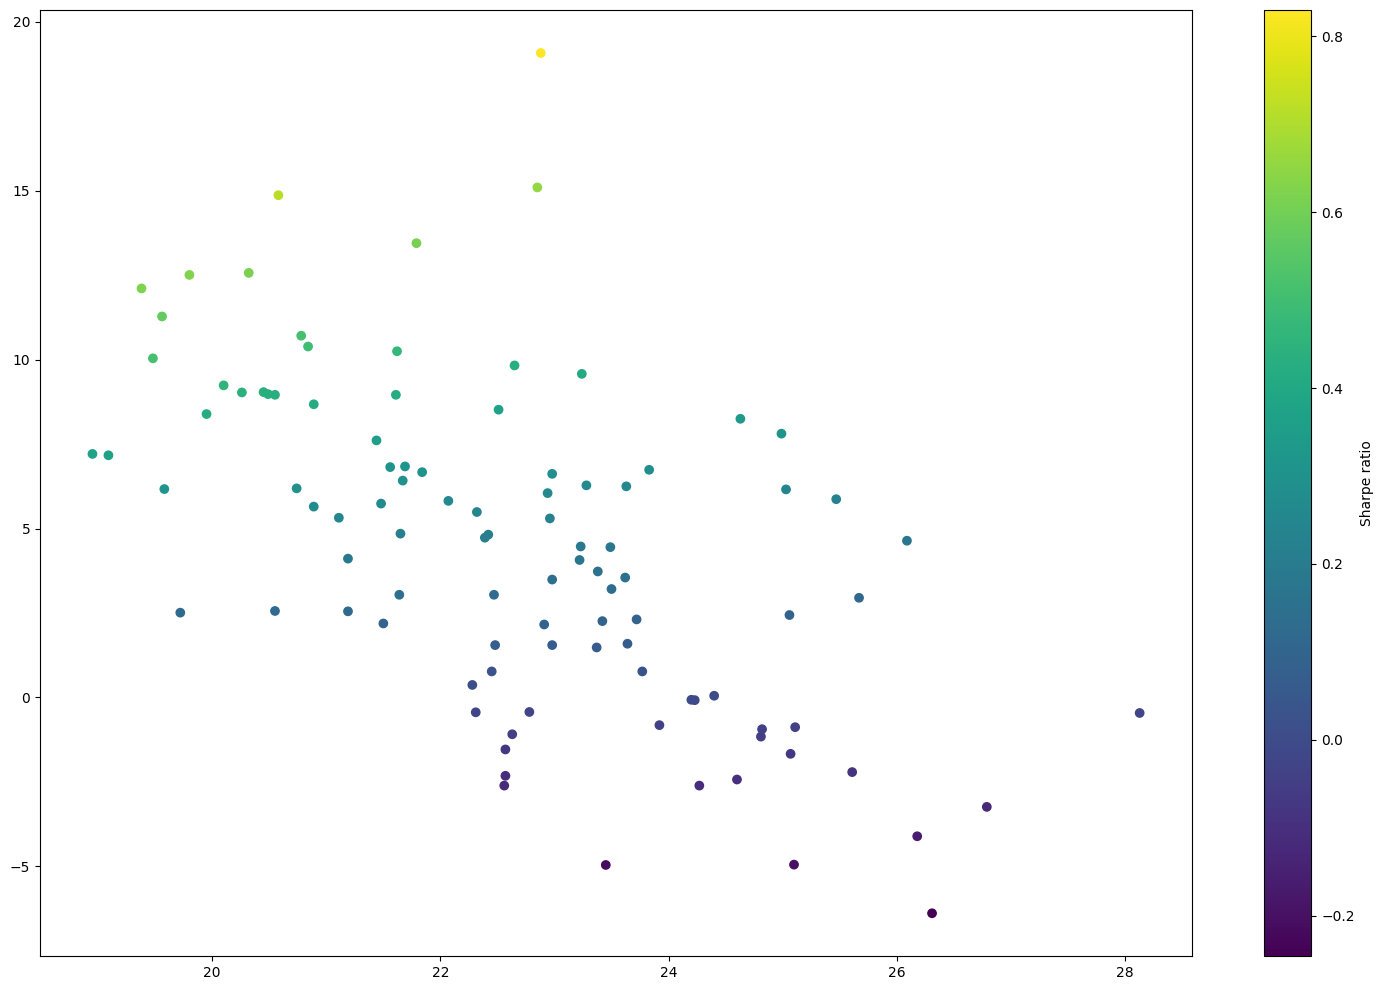

In [46]:
N = 100

for x in range (N):
    
    np.random.seed(x)
    
    # pesos aleatorios e normalizando
    w = np.random.random(9)
    w = np.array(w/w.sum())
    
    sigma = cov_portfolio(w, cov_matrix)*100
    
    ret = return_portfolio(w, mean).sum() *100
    sharp_r = (ret - tax_w_risk) / sigma

    simulacao.loc[x] = [round(w[0], 3), round(w[1],3), round(w[2],3),round(w[3],3),round(w[4],3),
                        round(w[5],3), round(w[6],3), round(w[7],3), round(w[8],3),
                        round(ret,2), round(sigma,2), round(sharp_r, 4)]

    
# Gráfico
plt.figure(figsize= (15,10))
plt.scatter(simulacao['Risco %'], simulacao['Retorno P %'], c = simulacao['Indice Sharpe'])
plt.colorbar(label = 'Sharpe ratio')
#plt.legend(bbox_to_anchor=(1.3, 0.6)) 
plt.tight_layout()   


In [47]:
maxi = simulacao['Indice Sharpe'].max()[0]
maxi

0.83

In [49]:
expected_r = expected_returns.capm_return(data)
estimative = risk_models.CovarianceShrinkage(data).ledoit_wolf()
ef1 = EfficientFrontier(expected_r, estimative)
ef1.max_sharpe()
ef1.portfolio_performance(verbose = True)

Expected annual return: 10.8%
Annual volatility: 21.4%
Sharpe Ratio: 0.41


(0.10845752290193847, 0.21357813838935316, 0.4141693694355567)

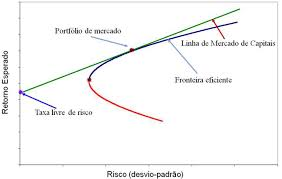

In [57]:
from PIL import Image

image = Image.open('image/fronteira_eficiente.jfif')
image

In [54]:
ef2 = CLA(expected_r, estimative)
ef2.min_volatility()
ef2.portfolio_performance(verbose = True,risk_free_rate=tax_w_risk)

Expected annual return: 7.9%
Annual volatility: 17.3%
Sharpe Ratio: -0.03


(0.07939195760220778, 0.17301617496605118, -0.034725322062929116)

In [51]:
ef3 = EfficientFrontier(expected_r, estimative)
ef3.max_quadratic_utility()
ef3.portfolio_performance(verbose = True, risk_free_rate=tax_w_risk)

Expected annual return: 13.1%
Annual volatility: 28.0%
Sharpe Ratio: 0.16


(0.13075279727908307, 0.2797185139956947, 0.16213727375865122)

In [ ]:
w_sharpe = dict(ef1.clean_weights())
w_risk = dict(ef2.clean_weights())
w_return = dict(ef3.clean_weights())

values_sharpe = np.dot(list(w_sharpe.values()),1000)
values_risk = np.dot(list(w_risk.values()),1000)
values_return = np.dot(list(w_return.values()),1000)
#################################################

In [ ]:
# oTIMIZAÇÃO PORTFOLIO HRP
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")

clusters = shc.linkage(returns.T, method='ward', metric='euclidean')

dendogram = shc.dendrogram(clusters, labels=returns.columns)

In [ ]:
def matrix_seriation(returns: pd.DataFrame):

    matrix_cov = returns.cov()

    dendogram = sns.clustermap(matrix_cov, method='ward', metric='euclidean')
    
    seriation = dendogram.dendrogram_col.reordered_ind
    columns_seriation = returns.columns[seriation]

    return (matrix_cov, columns_seriation)

In [ ]:
matrix_cov, columns_seriation = matrix_seriation(returns)

In [ ]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

In [ ]:
w_hrp = calcula_pesos_hrp(matrix_cov, columns_seriation)
w_hrp = list(w_hrp)
w_hrp

In [ ]:
w_sharpe
data.columns
columns_seriation
dict_columns = {}

for columns, value in zip(data.columns, w_hrp):
    
    dict_columns[columns] = w_hrp[list(columns_seriation).index(columns)]
    


In [ ]:
(ret - tax_w_risk) / sigma

In [ ]:
weights_ = np.array(list(dict_columns.values()))
sigma_ = cov_portfolio(weights_, cov_matrix)*100
 
ret_ = return_portfolio(weights_, mean).sum() *100
sharp_r_ = (ret_ - tax_w_risk) / sigma_
sharp_r_

In [ ]:
#values_hrp = np.dot(np.array(w_hrp) ,1000)
values_hrp = np.dot(weights_,1000)
returns['sharpe otm'] = 0
returns['cla otm'] = 0
returns['max_sqrt otm'] = 0
returns['hrp otm'] = 0


for i in range(len(data)-1):
    sum_all_sharpe = 0
    sum_all_risk = 0
    sum_all_return = 0
    sum_all_hrp = 0
    
    for x in range(len(values_sharpe)):
        
        # sum returns sharpe weights
        sharpe = (1+(returns.iloc[i,x]))* values_sharpe[x]
        sum_all_sharpe = sum_all_sharpe + sharpe
        values_sharpe[x] = sharpe
        
        # sum returns risk weights
        risk = (1+(returns.iloc[i,x]))* values_risk[x]
        sum_all_risk = sum_all_risk + risk
        values_risk[x] = risk
        
        # sum returns return weights
        return_ = (1+(returns.iloc[i,x]))* values_return[x]
        sum_all_return = sum_all_return + return_
        values_return[x] = return_
        
         # sum returns hrp weights
        hrp = (1+(returns.iloc[i,x]))* values_hrp[x]
        sum_all_hrp = sum_all_hrp + hrp
        values_hrp[x] = hrp
        
    returns['sharpe otm'].iloc[i] = sum_all_sharpe
    returns['cla otm'].iloc[i] = sum_all_risk
    returns['max_sqrt otm'].iloc[i] = sum_all_return
    returns['hrp otm'].iloc[i] = sum_all_hrp

In [ ]:
returns.head()

In [ ]:
date_list = []
date_test = list(x.date() for x in returns.index)
start = dt.datetime.strptime(date___, '%d/%m/%Y').date()
day = 30

while start <= end:
    
    if start in date_test:
        date_list.append(start)
    start = start + dt.timedelta(days = 1)
date_list

In [ ]:
def smooth(y, box_pts):
    
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode = 'valid')
    return y_smooth
       
#plt.title('Performance histórica')
#plt.xlabel('Dias');

In [ ]:
ibov = '^BVSP'
day = 365 * 3
ibov_start = dt.date.today() - dt.timedelta(days = day)
df_ibov = yf.download(ibov, start=ibov_start, end=dt.date.today())['Adj Close']
df_ibov

In [ ]:
sharpe_rent = returns['sharpe otm'] / returns['sharpe otm'][0] -1
cla_rent = returns['cla otm'] / returns['cla otm'][0] -1
max_sqrt_rent = returns['max_sqrt otm'] / returns['max_sqrt otm'][0] -1
hrp_rent = returns['hrp otm'] / returns['hrp otm'][0] -1
ibov_rent = df_ibov / df_ibov[0] -1

In [ ]:
# add dados np array 
fdr = smooth(ibov_rent,10)
fdr = np.append(fdr,ibov_rent[-1])
fdr

In [ ]:
figura = px.line(title = 'Historico')
figura.add_scatter(y = smooth(sharpe_rent,10), name = 'Índice Sharpe')
figura.add_scatter(y = smooth(cla_rent,10), name = 'Mínima Volatilidade')
figura.add_scatter(y = smooth(max_sqrt_rent,10), name = 'Máxima utilidade')
figura.add_scatter(y = smooth(hrp_rent,10), name = 'HRP')
figura.add_scatter(y = smooth(ibov_rent,10), name = 'IBOV')

In [ ]:
plt.plot( smooth(sharpe_rent,10) );
plt.plot( smooth(cla_rent,10) );
plt.plot( smooth(max_sqrt_rent,10) );
plt.plot( smooth(hrp_rent,10) );
plt.plot( smooth(ibov_rent,10) );
plt.legend(['Índice Sharpe', 'CLA', 'Maximo quadrado', 'HRP', 'IBOV']);
plt.xticks(rotation = 90)
plt.tight_layout();

In [ ]:
#plt.plot(returns.iloc[:,9:]);
returns.iloc[:,9:].plot(kind = 'line')
plt.legend(['Índice Sharpe', 'CLA', 'Maximo quadrado', 'HRP']);
plt.xticks(rotation = 90)
plt.tight_layout();

In [ ]:
rets = expected_returns.returns_from_prices(data)

In [ ]:
df_ = pd.DataFrame((returns.iloc[-1,-4:] /1000 -1) *100)
df_.columns = ['Rentabilidade']
df_['Rentabilidade'] = list(map(lambda x: f'{round(x,2)}%',df_.values.reshape(-1)))
df_

In [ ]:
# teste função HRP
from pypfopt.hierarchical_portfolio import HRPOpt

ef5 = HRPOpt(rets)
ef5.optimize()
ef5.portfolio_performance(verbose = True)

In [ ]:
# teste 
ef5.clean_weights(), w_hrp

In [ ]:
day = 365 * 3
str(dt.date.today() - dt.timedelta(days = day))

In [ ]:
returns.iloc[-1]

In [ ]:
returns_data = np.log1p(returns[['sharpe otm','cla otm','max_sqrt otm','hrp otm']].pct_change())
returns_data.fillna(0, inplace=True)

In [ ]:
returns_data

In [ ]:
mean_returns = returns_data.mean()
var_returns = returns_data.var()
drift = mean_returns - (0.5 * var_returns)
drift

In [ ]:
years = 3
days = 252 * years
simulation = 1000

In [ ]:
std_returns = returns_data.std()
std_returns

In [ ]:
Z = stats.norm.ppf(np.random.rand(days, simulation))
daily_sharpe = np.exp(drift[0] + std_returns[0] * Z)
daily_risk = np.exp(drift[1] + std_returns[1] * Z)
daily_returns = np.exp(drift[2] + std_returns[2] * Z)
daily_hrp = np.exp(drift[3] + std_returns[3] * Z)

In [ ]:
returns.iloc[-1]

In [ ]:
pred_sharpe = np.zeros_like(daily_sharpe)
pred_sharpe[0] = returns.iloc[-1,9]

pred_risk = np.zeros_like(daily_risk)
pred_risk[0] = returns.iloc[-1,10]

pred_returns = np.zeros_like(daily_returns)
pred_returns[0] = returns.iloc[-1,11]

pred_hrp = np.zeros_like(daily_hrp)
pred_hrp[0] = returns.iloc[-1,12]

In [ ]:
pred_hrp.shape

In [ ]:
for day in range(1, days):
  #print(dia)
    pred_sharpe[day] = pred_sharpe[day - 1] * daily_sharpe[day]
    pred_risk[day] = pred_risk[day - 1] * daily_risk[day]
    pred_returns[day] = pred_returns[day - 1] * daily_returns[day]
    pred_hrp[day] = pred_hrp[day - 1] * daily_hrp[day]
    

In [ ]:
# melhores projeçoes
max_sharpe = np.argmax(pred_sharpe[-1,:].flatten())
max_risk = np.argmax(pred_risk[-1,:].flatten())
max_retrun = np.argmax(pred_returns[-1,:].flatten())
max_hrp = np.argmax(pred_hrp[-1,:].flatten())

# piores projeções
min_sharpe = np.argmin(pred_sharpe[-1,:].flatten())
min_risk = np.argmin(pred_risk[-1,:].flatten())
min_retrun = np.argmin(pred_returns[-1,:].flatten())
min_hrp = np.argmin(pred_hrp[-1,:].flatten())

In [ ]:
fig = px.line(title = 'Simulações Índice sharpe')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_sharpe.T[max_sharpe], name = 'Melhor projeção');
fig.add_scatter(y = pred_sharpe.T[min_sharpe], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações CLA')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_risk.T[max_risk], name = 'Melhor projeção');
fig.add_scatter(y = pred_risk.T[min_risk], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações Máximo quadrado')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_returns.T[max_retrun], name = 'Melhor projeção');
fig.add_scatter(y = pred_returns.T[min_retrun], name = 'Pior projeção');

fig.show()

In [ ]:
fig = px.line(title = 'Simulações HRP')
#for i in range(len(pred_sharpe.T)):
fig.add_scatter(y = pred_hrp.T[max_hrp], name = 'Melhor projeção');
fig.add_scatter(y = pred_hrp.T[min_hrp], name = 'Pior projeção');

fig.show()

In [60]:
#!pip freeze > requirements.txt